In [1]:
cd /Users/james/signal

/Users/james/signal


In [2]:
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from beakerx import *
plt.style.use('ggplot')
import seaborn as sns
sns.set()
import h5py
import os
from tqdm import tqdm_notebook as tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn
import torch.utils.data
from torch.autograd import Variable # storing data while learning
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
#import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#from edward.models import Categorical, Mixture, Normal
from scipy import stats
from sklearn.model_selection import train_test_split
from torch import optim
from torch.utils import data as utilsdata
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler

Populating the interactive namespace from numpy and matplotlib


/Users/james/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
ls data_paper_WSNL

1000data.mat  location.mat*


In [4]:
def prepare_dataset(featurename='rss'):
    import scipy.io as sio  
    data_1 = sio.loadmat('data_paper_WSNL/1000data.mat')
    data_2 = sio.loadmat('data_paper_WSNL/location.mat')
    local = data_2['RXm'][:1000,:2]
    rss = data_1['data_db_rss']
    aoa = data_1['data_db_aoa']
    toa = data_1['data_db_toa']
    data_4 = data_1['data'][:,18:24]
    data_5 = data_1['data'][:,24:]
    data_6 = data_1['data'][:,6:]
    data_whole = np.concatenate((rss,aoa,toa,data_4,data_5),axis =1)
    local_x = local[:,:1]
    local_y = local[:,1:]
    if featurename=='whole':
        return train_test_split(data_whole, local, random_state=42)
    elif featurename=='rss':
        return train_test_split(rss, local, random_state=42)
    elif featurename=='aoa':
        return train_test_split(aoa, local, random_state=42)
    elif featurename=='toa':
        return train_test_split(toa, local, random_state=42)
    elif featurename=='data_4':
        return train_test_split(data_4, local, random_state=42)
    elif featurename=='data_5':
        return train_test_split(data_5, local, random_state=42)
    elif featurename=='data_6':
        return train_test_split(data_6, local, random_state=42)
X_train, X_test, y_train, y_test = prepare_dataset(featurename='data_6')
print("Size of features in training data: {}".format(X_train.shape))
print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

Size of features in training data: (750, 24)
Size of output in training data: (750, 2)
Size of features in test data: (250, 24)
Size of output in test data: (250, 2)


(array([29., 25., 34., 24., 33., 36., 35., 42., 33., 23., 23., 26., 35.,
        26., 42., 24., 32., 21., 15., 29., 30., 52., 32., 25., 29., 24.,
        34., 31., 33., 29., 30., 30., 33., 24., 32., 40., 28., 29., 28.,
        28., 30., 32., 36., 24., 34., 26., 26., 27., 25., 32.]),
 array([  900. ,  1092.6,  1285.2,  1477.8,  1670.4,  1863. ,  2055.6,
         2248.2,  2440.8,  2633.4,  2826. ,  3018.6,  3211.2,  3403.8,
         3596.4,  3789. ,  3981.6,  4174.2,  4366.8,  4559.4,  4752. ,
         4944.6,  5137.2,  5329.8,  5522.4,  5715. ,  5907.6,  6100.2,
         6292.8,  6485.4,  6678. ,  6870.6,  7063.2,  7255.8,  7448.4,
         7641. ,  7833.6,  8026.2,  8218.8,  8411.4,  8604. ,  8796.6,
         8989.2,  9181.8,  9374.4,  9567. ,  9759.6,  9952.2, 10144.8,
        10337.4, 10530. ]),
 <a list of 50 Patch objects>)

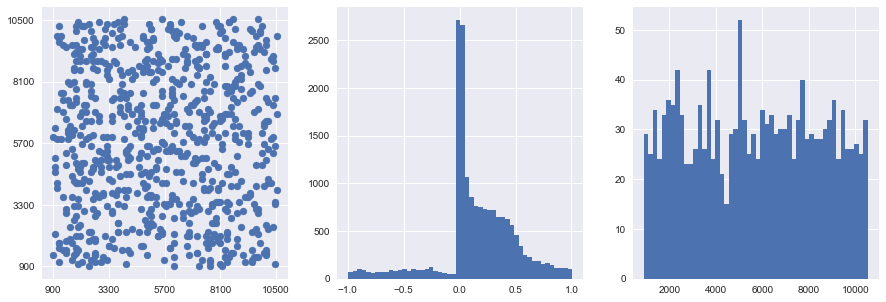

In [5]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].scatter(y_train[:,0],y_train[:,1])
ax[0].set_xticks(np.arange(900,10530,2400))
ax[0].set_yticks(np.arange(900,10530,2400))
ax[1].hist(X_train.ravel(),bins=50)
ax[2].hist(y_train.ravel(),bins=50)

fig,ax = plt.subplots(6,4,figsize=(16,20))
for i in range(6):
    for j in range(4):
        ax[i,j].hist(X_train[:,i*4+j],bins=50)

from sklearn.preprocessing import MinMaxScaler
def preprocess(data):
    scaler = MinMaxScaler()
    scaler.fit(data)
    return scaler.transform(data),scaler
scalers = {}
datas = [X_train, X_test, y_train, y_test]
for i in range(4):
    datas[i],scalers[i]  = preprocess(datas[i])
X_train, X_test, y_train, y_test = datas

fig,ax = plt.subplots(1,4,figsize=(16,4))
ax[0].hist(y_train[:,0],bins=50)
ax[1].hist(y_train[:,1],bins=50)
ax[2].hist(y_test[:,0],bins=50)
ax[3].hist(y_test[:,1],bins=50)

# MLP

In [6]:
# Dataloader
batch_size = 10
train = utilsdata.TensorDataset(torch.from_numpy(X_train.astype('float32')), torch.from_numpy(y_train.astype('float32')))
test = utilsdata.TensorDataset(torch.from_numpy(X_test.astype('float32')), torch.from_numpy(y_test.astype('float32')))
train_loader = torch.utils.data.DataLoader(
                 dataset=train,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test,
                batch_size=batch_size,
                shuffle=False)

In [7]:
## network
class MLPNet(nn.Module):
    def __init__(self,n_input = 24,n_hidden_1 = 20,n_hidden_2 = 16,n_hidden_3 = 10,n_hidden_4 = 6,n_output = 2,n_samples=750,epoch_num=100000):
        super(MLPNet, self).__init__()
        self.n_input  = n_input 
        self.n_hidden_1 = n_hidden_1 
        self.n_hidden_2 = n_hidden_2
        self.n_output =  n_output 
        self.fc1 = nn.Linear(n_input, n_hidden_1)
        self.fc2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.fc3 = nn.Linear(n_hidden_2, n_hidden_3)
        self.fc4 = nn.Linear(n_hidden_3, n_hidden_4)
        self.fc5 = nn.Linear(n_hidden_4, n_output)
    def forward(self, x):
        x = x.view(-1, self.n_input)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x
    
    def name(self):
        return "MLP"
use_cuda = False
## training
model =  MLPNet()
if use_cuda:
    model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [8]:
from torchsummary import summary
summary(model, (1,24))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]             500
            Linear-2                   [-1, 16]             336
            Linear-3                   [-1, 10]             170
            Linear-4                    [-1, 6]              66
            Linear-5                    [-1, 2]              14
Total params: 1,086
Trainable params: 1,086
Non-trainable params: 0
----------------------------------------------------------------


In [9]:
epochnum = 5000
aveloss = np.ndarray([epochnum])
for epoch in tqdm(range(epochnum)):
    # trainning
    ave_loss = 0
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        if use_cuda:
            x, target = x.cuda(), target.cuda()
        x, target = Variable(x), Variable(target)
        #print (x.size(),target.size())
        out = model(x)
        loss = criterion(out, target)
        ave_loss = ave_loss * 0.9 + loss.data[0] * 0.1
        loss.backward()
        optimizer.step()
    
        if (batch_idx+1) % 100 == 0 or (batch_idx+1) == len(train_loader):
            print ('==>>> epoch: {}, batch index: {}, train loss: {:.6f}'.format(
                epoch, batch_idx+1, ave_loss))
    aveloss[epoch] = ave_loss
#np.savetxt('loss7.27.txt',aveloss)

HBox(children=(IntProgress(value=0, max=5000), HTML(value=u'')))

==>>> epoch: 0, batch index: 75, train loss: 12372115.000000
==>>> epoch: 1, batch index: 75, train loss: 5543263.000000
==>>> epoch: 2, batch index: 75, train loss: 5239608.000000
==>>> epoch: 3, batch index: 75, train loss: 4698468.500000
==>>> epoch: 4, batch index: 75, train loss: 4416042.500000
==>>> epoch: 5, batch index: 75, train loss: 4523526.500000
==>>> epoch: 6, batch index: 75, train loss: 4428913.000000
==>>> epoch: 7, batch index: 75, train loss: 4348664.500000
==>>> epoch: 8, batch index: 75, train loss: 3852396.000000
==>>> epoch: 9, batch index: 75, train loss: 4455088.000000
==>>> epoch: 10, batch index: 75, train loss: 4174605.500000
==>>> epoch: 11, batch index: 75, train loss: 4318652.500000
==>>> epoch: 12, batch index: 75, train loss: 4706184.000000
==>>> epoch: 13, batch index: 75, train loss: 3869974.000000
==>>> epoch: 14, batch index: 75, train loss: 3806398.750000
==>>> epoch: 15, batch index: 75, train loss: 3836699.000000
==>>> epoch: 16, batch index: 75,

KeyboardInterrupt: 

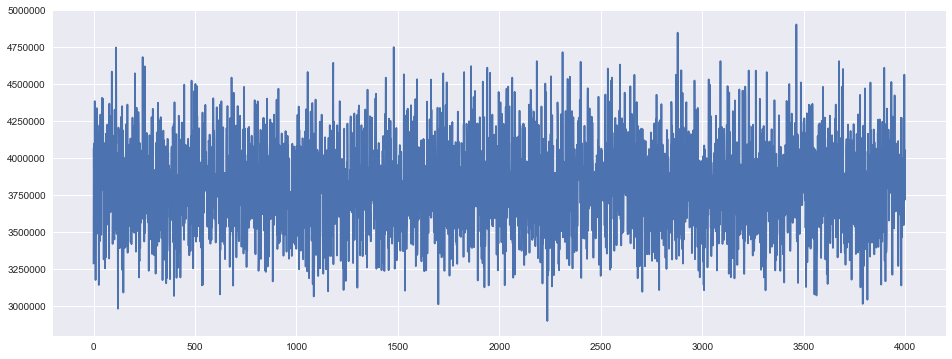

In [12]:
fig,ax=plt.subplots(1,figsize=(16,6))
ax.plot(aveloss[np.arange(1000,5000)])

In [24]:
n_input=24
x_test_data = X_test
x_test_tensor = torch.from_numpy(np.float32(x_test_data).reshape(250, n_input))
x_test_variable = Variable(x_test_tensor)
y_test_variable = model(x_test_variable)
y_testdata = y_test_variable.data.numpy()

In [25]:
y_testdata.shape,y_test.shape

((250, 2), (250, 2))

In [26]:
y_test

array([[ 5220,  3780],
       [ 3780,  7830],
       [ 9540,  5940],
       [ 2070,  9990],
       [ 7200,  9180],
       [ 9900,  5490],
       [ 7290,  2070],
       [ 7830,   900],
       [ 1260,  5850],
       [ 9270,  7200],
       [ 3150,  6480],
       [ 2790,  9450],
       [ 9180,  2970],
       [ 9900,  8550],
       [ 3240,  8010],
       [ 6930,  3600],
       [ 1170,  4140],
       [ 2790,  5670],
       [ 1800,  5760],
       [ 2160,  5040],
       [ 4320,  1530],
       [ 1350,  1440],
       [ 4500,  9270],
       [10260,  9180],
       [ 2880,  1440],
       [ 2070,  7650],
       [ 8550,  6300],
       [ 7110,  9090],
       [ 3420, 10440],
       [ 1890,  8730],
       [ 6210,  9810],
       [ 2340,  3600],
       [ 6570,  9180],
       [ 6840,  6750],
       [ 7110,  6210],
       [ 8730,  7200],
       [ 5850,  5940],
       [ 2790,  4320],
       [ 2520,  4320],
       [ 3060,  7650],
       [ 7200, 10080],
       [ 6390,  7110],
       [10260, 10260],
       [ 24

(250,) (250,) (250,) (250,)


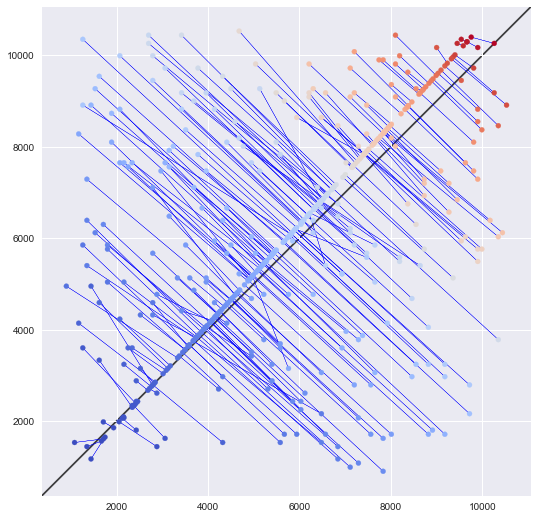

In [28]:
fig,ax=plt.subplots(1,figsize=(9,9))
c = np.sum(y_testdata**2+y_test**2,axis=1)
ax.scatter(y_testdata[:,0],y_testdata[:,1], s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)
ax.scatter(y_test[:,0],y_test[:,1], s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  
    np.max([ax.get_xlim(), ax.get_ylim()]),  
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
xorigin = y_testdata[:,0].ravel()
yorigin = y_testdata[:,1].ravel()
dx = y_test[:,0].ravel()-y_testdata[:,0].ravel()
dy = y_test[:,1].ravel()-y_testdata[:,1].ravel()
print (xorigin.shape, yorigin.shape, dx.shape, dy.shape)
#ax.arrow(xorigin[2], yorigin[2], dx[2], dy[2], color = 'b')
for i in range(y_testdata.shape[0]):
    ax.arrow(y_testdata[i,0],y_testdata[i,1],
            y_test[i,0]-y_testdata[i,0],y_test[i,1]-y_testdata[i,1],color = 'b')

In [29]:
def report_metrics(y_test_data,y_test):
    rmse = np.mean(np.sum((y_test_data - y_test)**2,axis=1)**0.5)
    pcc = scipy.stats.pearsonr(y_test_data.ravel(),y_test.ravel())
    return rmse,pcc
report_metrics(y_test_data,y_test)

(2190.7354, (0.7274497578285004, 1.7009136837428305e-83))

# Mixture Density Networks ##

Mixture Density Networks, developed by Christopher Bishop in the 1990s, **are one way to produce multiple outputs from a single input**. MDN predicts a *probability distribution* of possible output values. Then can sample several possible different output values for a given input.

This concept is quite powerful, and can be employed many current areas of machine learning research. It also allows us to calculate a sort of confidence factor in the predictions that the network is making.

The inverted sinusoid data we chose is not just a toy problem. In [the paper introducing MDNs](http://publications.aston.ac.uk/373/1/NCRG_94_004.pdf) an inverted sinusoid is used to describe the angle we need to move a robot arm to achieve a target location. MDNs are also used to model handwriting, where the next stroke is drawn from a probability distribution of multiple possibilities, rather than sticking to one prediction.

Bishop's implementation of MDNs will predict a class of probability distributions called Mixture of Gaussians or Gaussian Mixture Models, where the output value is modelled as a weighted sum of multiple Gaussians, each with different means and standard deviations.

So for each input $x$, we will predict a probability distribution function $P(y|x)$:

$P(y|x) = \sum_{k}^{K} \Pi_{k}(x) \phi(y, \mu_{k}(x), \sigma_{k}(x))$

- $k$ is an index describing which Gaussian we are referencing. There are $K$ Gaussians total.
- $\sum_{k}^{K}$ is the summation operator. We sum every $k$ Gaussian across all $K$. You might also see $\sum_{k=0}^{K-1}$ or $\sum_{k=1}^{K}$ depending on whether an author is using zero-based numbering or not.
- $\Pi_k$ acts as a weight, or multiplier, for mixing every $k$ Gaussian. It is a function of the input $x$: $\Pi_k(x)$
- $\phi$ is the Gaussian function and returns the at $y$ for a given mean and standard deviation.
- $\mu_k$ and $\sigma_k$ are the parameters for the $k$ Gaussian: mean $\mu_k$ and standard deviation $\sigma_k$. Instead of being fixed for each Gaussian, they are also functions of the input $x$: $\mu_k(x)$ and $\sigma_k(x)$

All of $\sigma_{k}$ are positive, and all of the weights $\Pi$ sum to one:

$\sum_{k}^{K} \Pi_{k} = 1$

First our network must learn the functions $\Pi_{k}(x), \mu_{k}(x), \sigma_{k}(x)$ for every $k$ Gaussian. Then these functions can be used to generate individual parameters $\mu_k, \sigma_k, \Pi_k$ for a given input $x$. These parameters will be used to generate our pdf $P(y|x)$. Finally, to make a prediction, we will need to sample (pick a value) from this pdf.

In our implementation, we will use a neural network of one hidden layer with 20 nodes. This will feed into another layer that generates the parameters for 5 mixtures: with 3 parameters $\Pi_k$, $\mu_k$, $\sigma_k$ for each Gaussian $k$.

Our definition will be split into three parts.

First we will compute 20 hidden values $z_h$ from our input $x$.

$z_h(x) = \tanh( W_{in} x + b_{in})$

Second, we will use these hidden values $z_h$ to compute our three sets of parameters $\Pi, \sigma, \mu$:

$
z_\Pi = W_{\Pi} z_h + b_{\Pi}\\
z_\sigma = W_{\sigma} z_h + b_{\sigma}\\
z_\mu = W_{\mu} z_h + b_{\mu}
$

Third, we will use the output of these layers to determine the parameters of the Gaussians.

$
\Pi = \frac{\exp(z_{\Pi})}{\sum_{k}^{K} \exp(z_{\Pi_k})}\\
\sigma = \exp(z_{\sigma})\\
\mu = z_{\mu}
$

- $\exp(x)$ is the exponential function also written as $e^x$

We use a [*softmax*](https://en.wikipedia.org/wiki/Softmax_function) operator to ensure that $\Pi$ sums to one across all $k$, and the exponential function ensures that each weight $\Pi_k$ is positive. We also use the exponential function to ensure that every $\sigma_k$ is positive.

Let's define our MDN network.

We cannot use the `MSELoss()` function for this task, because the output is an entire description of the probability distribution and not just a single value. A more suitable loss function is the logarithm of the likelihood of the output distribution vs the training data:

$loss(y | x) = -\log[ \sum_{k}^{K} \Pi_{k}(x) \phi(y, \mu_{k}(x), \sigma_{k}(x)) ]$

So for every $x$ input and $y$ output pair in the training data set, we can compute a loss based on the predicted distribution versus the actual distribution, and then attempt the minimise the sum of all the costs combined. To those who are familiar with logistic regression and cross entropy minimisation of softmax, this is a similar approach, but with non-discretised states.

We have to implement this cost function ourselves:
Let's create our MDN with 20 hidden nodes and 5 Gaussians.
We'll use a different optimizer this time called Adam that is more suited to this task.
We could generate more data to train the MDN, but what we have is nearly enough.
Finally, let's define a new training loop. We need a training loop that can handle the new loss function, and the MDN needs to train longer than the previous network.

In [27]:
# Dataloader
batch_size = 20
train = utilsdata.TensorDataset(torch.from_numpy(X_train.astype('float32')), torch.from_numpy(y_train.astype('float32')))
test = utilsdata.TensorDataset(torch.from_numpy(X_test.astype('float32')), torch.from_numpy(y_test.astype('float32')))
train_loader = torch.utils.data.DataLoader(
                 dataset=train,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test,
                batch_size=batch_size,
                shuffle=False)
#labels.unsqueeze(1).size(),sigma.size(),labels.unsqueeze(1).expand_as(sigma).size()

In [45]:
from torch.distributions import Categorical
import math

ONEOVERSQRT2PI = 1.0 / math.sqrt(2*math.pi)

class MDN(nn.Module):
    """A mixture density network layer
    The input maps to the parameters of a MoG probability distribution, where
    each Gaussian has O dimensions and diagonal covariance.
    Arguments:
        in_features (int): the number of dimensions in the input
        out_features (int): the number of dimensions in the output
        num_gaussians (int): the number of Gaussians per output dimensions
    Input:
        minibatch (BxD): B is the batch size and D is the number of input
            dimensions.
    Output:
        (pi, sigma, mu) (BxG, BxGxO, BxGxO): B is the batch size, G is the
            number of Gaussians, and O is the number of dimensions for each
            Gaussian. Pi is a multinomial distribution of the Gaussians. Sigma
            is the standard deviation of each Gaussian. Mu is the mean of each
            Gaussian.
    """
    def __init__(self, n_input =24,n_hidden_1 = 20,n_hidden_2 = 16,n_hidden_3 = 10,
                 n_out = 6,num_gaussians=4,sigma_min=10**(-6), sigma_max=10**(6)):
        super(MDN, self).__init__()
        self.n_input = n_input
        self.n_out = n_out
        self.num_gaussians = num_gaussians
        self.pi = nn.Sequential(
            nn.Linear(n_input, n_hidden_1),nn.ReLU(),nn.Linear(n_hidden_1, n_hidden_2),nn.ReLU(),
            nn.Linear(n_hidden_2,n_hidden_3),nn.ReLU(),nn.Linear(n_hidden_3,n_out),nn.ReLU(),
            nn.Linear(n_out,num_gaussians),
            nn.Softmax(dim=1)
        )
        self.sigma = nn.Sequential(nn.Linear(self.n_input, n_out*num_gaussians),nn.ReLU())
        self.mu = nn.Sequential(nn.Linear(self.n_input, n_out*num_gaussians),nn.ReLU())

    def forward(self, minibatch):
        pi = self.pi(minibatch)
         
        sigma = torch.exp(self.sigma(minibatch))
        #print (sigma)
        #sigma = sigma.view(-1, self.num_gaussians, self.n_out
        sigma = torch.clamp(sigma.view(-1, self.num_gaussians, self.n_out),10**(-6),10**(6))
        #print ('sigma after clip',sigma)
        mu = self.mu(minibatch)
        mu = mu.view(-1, self.num_gaussians, self.n_out)
        #print (mu,pi)
        return pi, sigma, mu


def gaussian_probability(sigma, mu, data):
    """Returns the probability of `data` given MoG parameters `sigma` and `mu`.
    
    Arguments:
        sigma (BxGxO): The standard deviation of the Gaussians. B is the batch
            size, G is the number of Gaussians, and O is the number of
            dimensions per Gaussian.
        mu (BxGxO): The means of the Gaussians. B is the batch size, G is the
            number of Gaussians, and O is the number of dimensions per Gaussian.
        data (BxI): A batch of data. B is the batch size and I is the number of
            input dimensions.
    Returns:
        probabilities (BxG): The probability of each point in the probability
            of the distribution in the corresponding sigma/mu index.
    """
    data = data.unsqueeze(1).expand_as(sigma)
    ret = ONEOVERSQRT2PI * torch.exp(-0.5 * ((data - mu) / sigma)**2) / sigma
    return torch.prod(ret, 2)
def mdn_loss(pi, sigma, mu, data):
    """Calculates the error, given the MoG parameters and the target
    The loss is the negative log likelihood of the data given the MoG
    parameters.
    """
    #print ('pi.size(), sigma.size(), mu.size(), data.size()',pi.size(), sigma.size(), mu.size(), data.size())
    prob = pi * gaussian_probability(sigma, mu, data)
    nll = -torch.log(torch.sum(prob, dim=1))
    return torch.mean(nll)
def sample(pi, sigma, mu):
    """Draw samples from a MoG.
    """
    categorical = Categorical(pi)
    pis = list(categorical.sample().data)
    sample = Variable(sigma.data.new(sigma.size(0), sigma.size(2)).normal_())
    for i, idx in enumerate(pis):
        sample[i] = sample[i].mul(sigma[i,idx]).add(mu[i,idx])
    return sample
model = nn.Sequential(
    nn.Linear(24, 20),
    nn.Tanh(),
    MDN(n_input =20,n_out=2)
)
optimizer = optim.Adam(model.parameters())
model

Sequential(
  (0): Linear(in_features=24, out_features=20, bias=True)
  (1): Tanh()
  (2): MDN(
    (pi): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=16, bias=True)
      (3): ReLU()
      (4): Linear(in_features=16, out_features=10, bias=True)
      (5): ReLU()
      (6): Linear(in_features=10, out_features=2, bias=True)
      (7): ReLU()
      (8): Linear(in_features=2, out_features=4, bias=True)
      (9): Softmax()
    )
    (sigma): Sequential(
      (0): Linear(in_features=20, out_features=8, bias=True)
      (1): ReLU()
    )
    (mu): Sequential(
      (0): Linear(in_features=20, out_features=8, bias=True)
      (1): ReLU()
    )
  )
)

In [46]:
losses= {}
for epoch in tqdm(range(500)):
    for minibatch, (x, labels) in enumerate(train_loader):
        model.zero_grad()
        pi, sigma, mu = model(x)
        #print (pi.size(), sigma.size(), mu.size(),labels.size())
        loss = mdn_loss(pi, sigma, mu, labels)
        loss.backward()
        optimizer.step()    
        if (minibatch+1) % 100 == 0 or (minibatch+1) == len(train_loader):
            print ('==>>> epoch: {}, batch index: {}, train loss: {:.6f}'.format(
                epoch, batch_idx+1, loss.data[0]))
            #print (pi, sigma, mu)
    losses[epoch] = loss.data[0]

HBox(children=(IntProgress(value=0, max=500), HTML(value=u'')))

==>>> epoch: 0, batch index: 17, train loss: nan
==>>> epoch: 1, batch index: 17, train loss: nan
==>>> epoch: 2, batch index: 17, train loss: nan
==>>> epoch: 3, batch index: 17, train loss: nan
==>>> epoch: 4, batch index: 17, train loss: nan
==>>> epoch: 5, batch index: 17, train loss: nan
==>>> epoch: 6, batch index: 17, train loss: nan
==>>> epoch: 7, batch index: 17, train loss: nan
==>>> epoch: 8, batch index: 17, train loss: nan
==>>> epoch: 9, batch index: 17, train loss: nan
==>>> epoch: 10, batch index: 17, train loss: nan
==>>> epoch: 11, batch index: 17, train loss: nan
==>>> epoch: 12, batch index: 17, train loss: nan
==>>> epoch: 13, batch index: 17, train loss: nan
==>>> epoch: 14, batch index: 17, train loss: nan
==>>> epoch: 15, batch index: 17, train loss: nan
==>>> epoch: 16, batch index: 17, train loss: nan
==>>> epoch: 17, batch index: 17, train loss: nan
==>>> epoch: 18, batch index: 17, train loss: nan
==>>> epoch: 19, batch index: 17, train loss: nan
==>>> epoc

==>>> epoch: 166, batch index: 17, train loss: nan
==>>> epoch: 167, batch index: 17, train loss: nan
==>>> epoch: 168, batch index: 17, train loss: nan
==>>> epoch: 169, batch index: 17, train loss: nan
==>>> epoch: 170, batch index: 17, train loss: nan
==>>> epoch: 171, batch index: 17, train loss: nan
==>>> epoch: 172, batch index: 17, train loss: nan
==>>> epoch: 173, batch index: 17, train loss: nan
==>>> epoch: 174, batch index: 17, train loss: nan
==>>> epoch: 175, batch index: 17, train loss: nan
==>>> epoch: 176, batch index: 17, train loss: nan
==>>> epoch: 177, batch index: 17, train loss: nan
==>>> epoch: 178, batch index: 17, train loss: nan
==>>> epoch: 179, batch index: 17, train loss: nan
==>>> epoch: 180, batch index: 17, train loss: nan
==>>> epoch: 181, batch index: 17, train loss: nan
==>>> epoch: 182, batch index: 17, train loss: nan
==>>> epoch: 183, batch index: 17, train loss: nan
==>>> epoch: 184, batch index: 17, train loss: nan
==>>> epoch: 185, batch index: 

==>>> epoch: 330, batch index: 17, train loss: nan
==>>> epoch: 331, batch index: 17, train loss: nan
==>>> epoch: 332, batch index: 17, train loss: nan
==>>> epoch: 333, batch index: 17, train loss: nan
==>>> epoch: 334, batch index: 17, train loss: nan
==>>> epoch: 335, batch index: 17, train loss: nan
==>>> epoch: 336, batch index: 17, train loss: nan
==>>> epoch: 337, batch index: 17, train loss: nan
==>>> epoch: 338, batch index: 17, train loss: nan
==>>> epoch: 339, batch index: 17, train loss: nan
==>>> epoch: 340, batch index: 17, train loss: nan
==>>> epoch: 341, batch index: 17, train loss: nan
==>>> epoch: 342, batch index: 17, train loss: nan
==>>> epoch: 343, batch index: 17, train loss: nan
==>>> epoch: 344, batch index: 17, train loss: nan
==>>> epoch: 345, batch index: 17, train loss: nan
==>>> epoch: 346, batch index: 17, train loss: nan
==>>> epoch: 347, batch index: 17, train loss: nan
==>>> epoch: 348, batch index: 17, train loss: nan
==>>> epoch: 349, batch index: 

==>>> epoch: 492, batch index: 17, train loss: nan
==>>> epoch: 493, batch index: 17, train loss: nan
==>>> epoch: 494, batch index: 17, train loss: nan
==>>> epoch: 495, batch index: 17, train loss: nan
==>>> epoch: 496, batch index: 17, train loss: nan
==>>> epoch: 497, batch index: 17, train loss: nan
==>>> epoch: 498, batch index: 17, train loss: nan
==>>> epoch: 499, batch index: 17, train loss: nan


In [40]:
np.isnan(y_train).sum()

0

In [47]:
sys.path.append('bin')

In [49]:
import mdn

In [50]:
model = nn.Sequential(
    nn.Linear(24, 20),
    nn.Tanh(),
    mdn.MDN(20, 2, 5)
)

In [51]:
losses= {}
for epoch in tqdm(range(500)):
    for minibatch, (x, labels) in enumerate(train_loader):
        model.zero_grad()
        pi, sigma, mu = model(x)
        #print (pi.size(), sigma.size(), mu.size(),labels.size())
        loss = mdn_loss(pi, sigma, mu, labels)
        loss.backward()
        optimizer.step()    
        if (minibatch+1) % 100 == 0 or (minibatch+1) == len(train_loader):
            print ('==>>> epoch: {}, batch index: {}, train loss: {:.6f}'.format(
                epoch, batch_idx+1, loss.data[0]))
            #print (pi, sigma, mu)
    losses[epoch] = loss.data[0]

HBox(children=(IntProgress(value=0, max=500), HTML(value=u'')))

==>>> epoch: 0, batch index: 17, train loss: inf
==>>> epoch: 1, batch index: 17, train loss: inf
==>>> epoch: 2, batch index: 17, train loss: inf
==>>> epoch: 3, batch index: 17, train loss: inf
==>>> epoch: 4, batch index: 17, train loss: inf
==>>> epoch: 5, batch index: 17, train loss: inf
==>>> epoch: 6, batch index: 17, train loss: inf
==>>> epoch: 7, batch index: 17, train loss: inf
==>>> epoch: 8, batch index: 17, train loss: inf
==>>> epoch: 9, batch index: 17, train loss: inf
==>>> epoch: 10, batch index: 17, train loss: inf
==>>> epoch: 11, batch index: 17, train loss: inf
==>>> epoch: 12, batch index: 17, train loss: inf
==>>> epoch: 13, batch index: 17, train loss: inf
==>>> epoch: 14, batch index: 17, train loss: inf
==>>> epoch: 15, batch index: 17, train loss: inf
==>>> epoch: 16, batch index: 17, train loss: inf
==>>> epoch: 17, batch index: 17, train loss: inf
==>>> epoch: 18, batch index: 17, train loss: inf
==>>> epoch: 19, batch index: 17, train loss: inf
==>>> epoc

==>>> epoch: 164, batch index: 17, train loss: inf
==>>> epoch: 165, batch index: 17, train loss: inf
==>>> epoch: 166, batch index: 17, train loss: inf
==>>> epoch: 167, batch index: 17, train loss: inf
==>>> epoch: 168, batch index: 17, train loss: inf
==>>> epoch: 169, batch index: 17, train loss: inf
==>>> epoch: 170, batch index: 17, train loss: inf
==>>> epoch: 171, batch index: 17, train loss: inf
==>>> epoch: 172, batch index: 17, train loss: inf
==>>> epoch: 173, batch index: 17, train loss: inf
==>>> epoch: 174, batch index: 17, train loss: inf
==>>> epoch: 175, batch index: 17, train loss: inf
==>>> epoch: 176, batch index: 17, train loss: inf
==>>> epoch: 177, batch index: 17, train loss: inf
==>>> epoch: 178, batch index: 17, train loss: inf
==>>> epoch: 179, batch index: 17, train loss: inf
==>>> epoch: 180, batch index: 17, train loss: inf
==>>> epoch: 181, batch index: 17, train loss: inf
==>>> epoch: 182, batch index: 17, train loss: inf
==>>> epoch: 183, batch index: 

==>>> epoch: 325, batch index: 17, train loss: inf
==>>> epoch: 326, batch index: 17, train loss: inf
==>>> epoch: 327, batch index: 17, train loss: inf
==>>> epoch: 328, batch index: 17, train loss: inf
==>>> epoch: 329, batch index: 17, train loss: inf
==>>> epoch: 330, batch index: 17, train loss: inf
==>>> epoch: 331, batch index: 17, train loss: inf
==>>> epoch: 332, batch index: 17, train loss: inf
==>>> epoch: 333, batch index: 17, train loss: inf
==>>> epoch: 334, batch index: 17, train loss: inf
==>>> epoch: 335, batch index: 17, train loss: inf
==>>> epoch: 336, batch index: 17, train loss: inf
==>>> epoch: 337, batch index: 17, train loss: inf
==>>> epoch: 338, batch index: 17, train loss: inf
==>>> epoch: 339, batch index: 17, train loss: inf
==>>> epoch: 340, batch index: 17, train loss: inf
==>>> epoch: 341, batch index: 17, train loss: inf
==>>> epoch: 342, batch index: 17, train loss: inf
==>>> epoch: 343, batch index: 17, train loss: inf
==>>> epoch: 344, batch index: 

==>>> epoch: 486, batch index: 17, train loss: inf
==>>> epoch: 487, batch index: 17, train loss: inf
==>>> epoch: 488, batch index: 17, train loss: inf
==>>> epoch: 489, batch index: 17, train loss: inf
==>>> epoch: 490, batch index: 17, train loss: inf
==>>> epoch: 491, batch index: 17, train loss: inf
==>>> epoch: 492, batch index: 17, train loss: inf
==>>> epoch: 493, batch index: 17, train loss: inf
==>>> epoch: 494, batch index: 17, train loss: inf
==>>> epoch: 495, batch index: 17, train loss: inf
==>>> epoch: 496, batch index: 17, train loss: inf
==>>> epoch: 497, batch index: 17, train loss: inf
==>>> epoch: 498, batch index: 17, train loss: inf
==>>> epoch: 499, batch index: 17, train loss: inf


Once the training is finished, we can observe all the parameters for the Gaussians and see how they vary with respect to the input $x$.

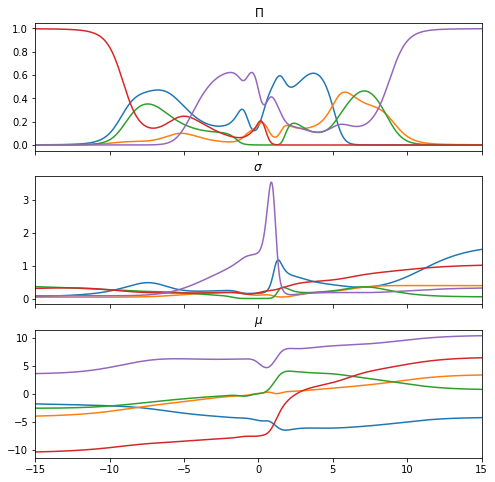

In [48]:
pi_variable, sigma_variable, mu_variable = model(x_test_variable)

pi_data = pi_variable.data.numpy()
sigma_data = sigma_variable.data.numpy()
mu_data = mu_variable.data.numpy()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,8))
ax1.plot(x_test_data, pi_data)
ax1.set_title('$\Pi$')
ax2.plot(x_test_data, sigma_data)
ax2.set_title('$\sigma$')
ax3.plot(x_test_data, mu_data)
ax3.set_title('$\mu$')
plt.xlim([-15,15])
plt.show()

We can also plot the $\mu$ of each Gaussian with respect to $x$, and show the range of by highlighting a region between $\mu-\sigma$ and $\mu+\sigma$.

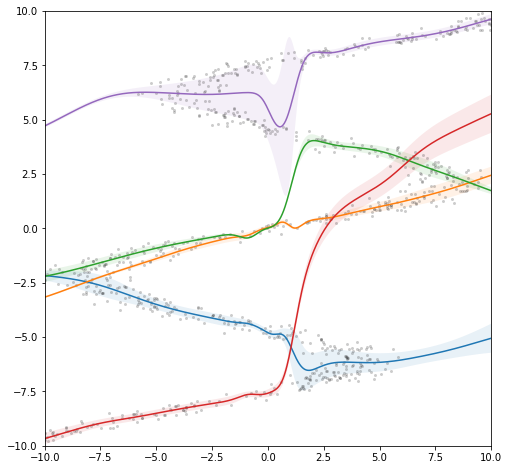

In [49]:
plt.figure(figsize=(8, 8), facecolor='white')
for mu_k, sigma_k in zip(mu_data.T, sigma_data.T):
    plt.plot(x_test_data, mu_k)
    plt.fill_between(x_test_data, mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)
plt.scatter(mdn_x_data, mdn_y_data, marker='.', lw=0, alpha=0.2, c='black')
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.show()

In the plot above, we see that for every point on the $x$-axis, there are multiple lines or states where $y$ may be, and we select these states with probabilities modelled by $\Pi$. Note that the network won't find an ideal solution every time. It's possible to get lower loss by using more Gaussians, but the results are harder to interpret.

If we want to sample from the network we will need to pick a Gaussian $k$ and pick a value (sample) from that Gaussian. Here we use a trick called [Gumbel softmax sampling](http://timvieira.github.io/blog/post/2014/07/31/gumbel-max-trick/) to pick our $k$. We treat the $\Pi$ weights as a discrete distribution of probabilities, and sample one $k$ for each row of `pi_data`.

In [50]:
def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

k = gumbel_sample(pi_data)

Now that we have selected $k$ for each row, we can select $\sigma$ and $\mu$ as well. We will use `np.random.randn` to sample from each Gaussian, scaling it by $\sigma$ and offsetting it by $\mu$.

In [51]:
indices = (np.arange(n_samples), k)
rn = np.random.randn(n_samples)
sampled = rn * sigma_data[indices] + mu_data[indices]

With these sampled $y$ values, we can overlay them on the original distribution to see how accurately the network captures the shape.

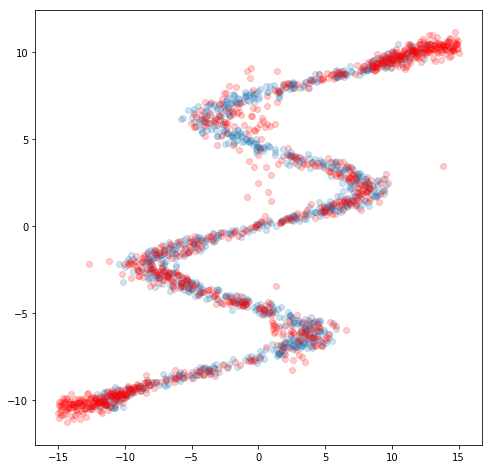

In [52]:
plt.figure(figsize=(8, 8))
plt.scatter(mdn_x_data, mdn_y_data, alpha=0.2)
plt.scatter(x_test_data, sampled, alpha=0.2, color='red')
plt.show()

Some other things to try:
    
- What other constraints might we enforce? Is it ever helpful to encourage $\Pi$ to be sparse to maintain a "simple" distribution?
- What kinds of regularization can we add to the network?
- Often very small sigma can create problems, it might be helpful to add `sigma += 0.01` inside the MDN.
- How do more or fewer Gaussians affect the result?
- How do more or fewer hidden nodes affect the result?
- What other kinds of nonlinear activation functions work besides `Tanh()`? Try `Sigmoid()` too.
- How do these plots move if you draw them in realtime while the network is training?
- What happens when if you use the [*softplus*](https://en.wikipedia.org/wiki/Softplus) function for making the $\sigma$ positive, instead of $\exp(x)$?